In [34]:
#import of needed packages
import pandas as pd

import re

import numpy as np

import gensim

import spacy

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

np.random.seed(4)

import string
#from spellchecker import SpellChecker
pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns',50)
pd.set_option('display.width',5000)
pd.set_option('max_colwidth', 500)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

from gensim.models import CoherenceModel
from gensim import corpora, models

from matplotlib import pyplot as plt
import spacy
from gensim.corpora.dictionary import Dictionary

In [78]:
nlp = spacy.load("en_core_web_sm") #loading package needed for lemmatizing words and part-of-speech tagging

Importing data

In [79]:
#data_tweets = pd.read_csv('twcs.csv', sep = ',') 

Preprocessing of the text data

In [80]:
def preprocess(text):
    if type(text) is not str:
        return
    result = []
    text = text.lower() #lowercase
    text = re.sub('http://\S+|https://\S+', '', text)  # remove urls
    text = re.sub('@\S+', '', text)  #remove mentions
    text = re.sub('_{2}\w+_{2}', '', text) #remove masked data
    text = re.sub('\d', '', text) #remove digits
    text = re.sub('’|‘', '', text) #remove additional punctuation
    
    #remove emojis
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)
    
    text = text.translate(str.maketrans('', '', string.punctuation)) #remove punctuation
            
    return " ".join(text.split())

In [81]:
data_tweets['clean_text'] = data_tweets["text"].apply(lambda x: preprocess(x))

In [83]:
def lemmatize(text):
    lemmatized_text = []
    text_nlp = nlp(text)
    lemmatized_text = [str(token.lemma_) for token in text_nlp # only nouns, verbs, adjectives and adverbs 
                  if (token.pos_ in ['NOUN', 'ADV', 'VERB', 'ADJ']) and token.text not in nlp.Defaults.stop_words] 
   
    return lemmatized_text

In [ ]:
import time
start_time = time.time()
data_tweets['lemma_text'] = data_tweets["clean_text"].apply(lambda x: lemmatize(x))
print("--- %s seconds ---" % (time.time() - start_time)) #cca. 3 sata

In [ ]:
#data_tweets.to_csv('twcs_better.csv', sep = ',', index = False)

## Extracting the most common companies to reduce noise in data

In [ ]:
#data_tweets = pd.read_csv('twcs_better.csv', sep = ',')

In [47]:
first_inbound = data_tweets[pd.isnull(data_tweets.in_response_to_tweet_id) & data_tweets.inbound] #first inbound messages

In [48]:
inbounds_and_outbounds = pd.merge(first_inbound, data_tweets, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id') # all tweets in response merged
inbounds_and_outbounds = inbounds_and_outbounds[inbounds_and_outbounds.inbound_y ^ True]

In [49]:
perc_authors = inbounds_and_outbounds.author_id_y.value_counts().rename_axis('unique_values').to_frame('counts')

perc_authors['Ratio'] = perc_authors.counts / inbounds_and_outbounds.shape[0] * 100

perc_authors['Cum_sum'] = perc_authors.Ratio.cumsum()

In [50]:
list_comp = perc_authors[perc_authors['Cum_sum'] <= 90].index.values.tolist() #taking companies where cumulative sum of ratio of tweets <= 90%

In [51]:
list_of_tweets = inbounds_and_outbounds[inbounds_and_outbounds.author_id_y.isin(list_comp)].tweet_id_x.unique().tolist()
list_of_tweets_2 = data_tweets[data_tweets.author_id.isin(list_comp)].tweet_id.unique().tolist()
list_of_tweets_final = list_of_tweets + list_of_tweets_2
print(len(list_of_tweets_final))

1800036


In [52]:
data_mini = data_tweets[data_tweets.tweet_id.isin(list_of_tweets_final)].copy()

In [ ]:
#data_mini.to_csv('twcs_mini.csv', sep = ',', index = False)

Working with smaller dataset - only top 48 companies

In [64]:
data_mini = pd.read_csv('twcs_mini.csv', sep = ',')

In [65]:
print(data_mini.shape)

(1800036, 9)


Import of extracted small dataset for testing relevance of predicted topics (this tweets will be deleted from training dataset)

In [66]:
data_test= pd.read_csv('data_test.csv', sep = ',')

In [67]:
data_mini[data_mini.tweet_id.isin(data_test.tweet_id)].shape

(11, 9)

In [68]:
data_mini = data_mini[~data_mini.tweet_id.isin(data_test.tweet_id)].copy()

In [69]:
print(data_mini.shape)

(1800025, 9)


## Selecting only customers' tweets because company answers are mostly too generic to extract a topic

In [70]:
data_mini = data_mini[data_mini.author_id.str.isnumeric() == True].copy()

In [71]:
#dataset is also faster to train when leaving only 'questions'
print(data_mini.shape)

(658775, 9)


In [72]:
data_mini.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,clean_text,lemma_text
3,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,is the worst customer service,"['bad', 'customer', 'service']"
7,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,"@115714 y’all lie about your “great” connection. 5 bars LTE, still won’t load something. Smh.",17,NaN,yall lie about your “great” connection bars lte still wont load something smh,"['lie', 'great', 'connection', 'bar', 'lte', 'still', 'load', 'smh']"
9,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, they tell me I have shortcode enabled on my account, but I have never in the 4 years I've tried https://t.co/0G98RtNxPK",19,NaN,whenever i contact customer support they tell me i have shortcode enabled on my account but i have never in the years ive tried,"['whenever', 'contact', 'customer', 'support', 'tell', 'have', 'shortcode', 'enable', 'account', 'never', 'year', 'try']"
14,29,115716,True,Tue Oct 31 22:01:35 +0000 2017,actually that's a broken link you sent me and incorrect information https://t.co/V4yfrHR8VI,28,NaN,actually thats a broken link you sent me and incorrect information,"['actually', 's', 'broken', 'link', 'send', 'incorrect', 'information']"
16,31,115717,True,Tue Oct 31 22:06:54 +0000 2017,"Yo @Ask_Spectrum, your customer service reps are super nice— but imma start trippin if y’all don’t get my service going!",30,NaN,yo your customer service reps are super nice— but imma start trippin if yall dont get my service going,"['customer', 'service', 'rep', 'super', 'nice', 'imma', 'start', 'trippin', 'get', 'service', 'go']"


In [73]:
data_mini.reset_index(inplace = True)

Additional removal of some words that do not add meaning to topics and some symbols

In [74]:
def lemma(text):
    words = []
    text = re.sub('\]|\[|\,|\'', '', text)
    text = re.sub('\\\\ud200', '', text)
    text = re.sub('。', '', text)
    for i in text.split():
        if i:
            words.append(i)
    return words

In [75]:
data_mini['lemma_text_new'] = data_mini["lemma_text"].apply(lambda x: lemma(x))

In [76]:
my_stop_words = STOPWORDS.union(set(['do', 'so', 'be', 'go', 'i', 'm', 're', 'have','why', 'when', 'how', 're', 'then', 's', 'get', 'try',
                                    'e', 'aa', 'fuck', 'r', 'fucking', ]))

In [77]:
def remove_more_stop(text):
    new_text = []
    for word in text:
        if (word not in my_stop_words):
            new_text.append(word)
    return new_text

In [78]:
data = data_mini[['lemma_text_new']].copy()

In [79]:
data['lemma_text_new'] = data.lemma_text_new.apply(lambda x: remove_more_stop(x))

Creating dictionary

In [18]:
dictionary = gensim.corpora.Dictionary(data.lemma_text_new)

In [19]:
print(len(dictionary))

154775


In [20]:
#filtering rare and too common words in dictionary
dictionary.filter_extremes(no_below=500, no_above=0.7) 

In [21]:
print(len(dictionary))

1278


In [61]:
#dictionary.save('dictionary')

In [92]:
#dictionary = Dictionary.load('dictionary')

Most common words in dictionary

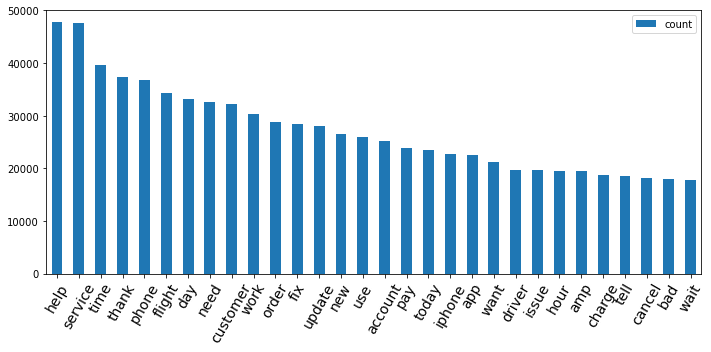

In [22]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']
cleansed_words_df.sort_values('count', ascending=False, inplace=True)
cleansed_words_df.iloc[0:30].plot(kind = 'bar', rot=60, figsize=(10,5))
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()

Creating corpus

In [23]:
bow_corpus = [dictionary.doc2bow(doc) for doc in data.lemma_text_new]

TF-IDF

In [24]:
tfidf = models.TfidfModel(bow_corpus)
#tfidf.save('tfidf')
corpus_tfidf = tfidf[bow_corpus]

In [293]:
#tfidf = models.TfidfModel.load('tfidf')

Choosing number of topics and hyperparameters by coherence score

In [25]:
alpha = ['symmetric', 'asymmetric']
eta = ['symmetric', 'auto']
min_topics = 5
max_topics = 16
topics_num = list(range(min_topics, max_topics))
model_indexes = range(44)

In [26]:
coherence_values = []
i=0
for num_topics in topics_num:
    for a in alpha:
        for e in eta:
            model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary, passes=2, 
                                               workers=4, alpha = a , eta = e)
            coherencemodel = CoherenceModel(model=model,texts = data.lemma_text_new, corpus=corpus_tfidf, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
            print('Index:', i, 'num. topics:', num_topics, 'alpha:', a, 'eta', e, 'coherence:', coherencemodel.get_coherence())
            i=i+1

Index: 0 num. topics: 5 alpha: symmetric eta symmetric coherence: 0.3848132780980559
Index: 1 num. topics: 5 alpha: symmetric eta auto coherence: 0.3347742366425899
Index: 2 num. topics: 5 alpha: asymmetric eta symmetric coherence: 0.36062740284322575
Index: 3 num. topics: 5 alpha: asymmetric eta auto coherence: 0.33287836657966796
Index: 4 num. topics: 6 alpha: symmetric eta symmetric coherence: 0.3988665039318799
Index: 5 num. topics: 6 alpha: symmetric eta auto coherence: 0.3706457151364537
Index: 6 num. topics: 6 alpha: asymmetric eta symmetric coherence: 0.27555181350020946
Index: 7 num. topics: 6 alpha: asymmetric eta auto coherence: 0.3126870305290125
Index: 8 num. topics: 7 alpha: symmetric eta symmetric coherence: 0.42303739393745415
Index: 9 num. topics: 7 alpha: symmetric eta auto coherence: 0.4262531862812836
Index: 10 num. topics: 7 alpha: asymmetric eta symmetric coherence: 0.2931590915039316
Index: 11 num. topics: 7 alpha: asymmetric eta auto coherence: 0.286275262431708

In [27]:
max_by_topic = []
start = 0
stop =  start + 4
while start <= 40:
    max_by_topic.append(max(coherence_values[start:stop]))
    start = start + 4
    stop = stop + 4

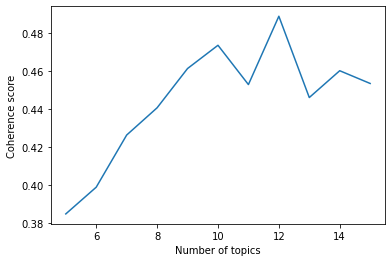

In [28]:
plt.plot(topics_num,max_by_topic)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")

plt.show()

## Final model with chosen hyperparameters

Model is chosen based on coherence score and topic relevance

In [29]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=12, id2word=dictionary, passes=2, workers=1, random_state = 13,
                                            alpha = 'symmetric', eta = 'auto')

Topics:

In [30]:
lda_model.show_topics(num_topics=12, num_words=10, log=False, formatted=True)

[(0,
  '0.039*"dm" + 0.023*"question" + 0.022*"send" + 0.021*"answer" + 0.021*"reply" + 0.019*"check" + 0.016*"read" + 0.016*"respond" + 0.015*"response" + 0.015*"line"'),
 (1,
  '0.053*"flight" + 0.024*"fly" + 0.021*"thank" + 0.017*"seat" + 0.016*"delay" + 0.016*"ticket" + 0.015*"book" + 0.014*"travel" + 0.012*"plane" + 0.012*"bag"'),
 (2,
  '0.024*"play" + 0.022*"game" + 0.018*"app" + 0.018*"music" + 0.016*"spotify" + 0.016*"watch" + 0.013*"tv" + 0.013*"download" + 0.012*"load" + 0.012*"speed"'),
 (3,
  '0.030*"account" + 0.019*"help" + 0.018*"log" + 0.017*"password" + 0.016*"sign" + 0.015*"reset" + 0.015*"number" + 0.014*"device" + 0.014*"connect" + 0.014*"network"'),
 (4,
  '0.036*"iphone" + 0.033*"fix" + 0.032*"update" + 0.029*"phone" + 0.022*"shit" + 0.020*"io" + 0.017*"i️" + 0.016*"new" + 0.015*"battery" + 0.013*"slow"'),
 (5,
  '0.030*"train" + 0.017*"complaint" + 0.014*"report" + 0.014*"chat" + 0.013*"follow" + 0.013*"connection" + 0.013*"hold" + 0.012*"late" + 0.012*"poor" + 

Visualization of the topics:

In [31]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus_tfidf, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [63]:
#lda_model.save('lda.model')

In [297]:
#lda_model = gensim.models.LdaMulticore.load('lda.model')

Deciding on topics based on most relevant words:

In [39]:
dictionary_topics = {4: 'Phone problems (mostly iPhone): battery, glitch, crash, freeze', 
                     5: 'Train problems (late etc.)',
                     3: 'Problems with account/password/logging', 
                     9: 'Problem with websites',
                     8: 'Problems with package delivery', 
                     11:'Bad customer service', 
                     7: 'Problems with taxi rides (Uber, Lyft)', 
                     6: 'Food category ',
                     10: 'Internet problems (outage etc.)', 
                     0: 'General questions, customer support',
                     2: 'Problems with apps (download, speed) and games',
                     1: 'Problems with travel (mostly airlines delays etc.)',
                     -1: 'Unknown'}

Applying model to small test dataset to test it on unseen tweets:

In [84]:
data_test['lemma_text_new'] = data_test["lemma_text"].apply(lambda x: lemma(x))

In [85]:
data_test['lemma_text_new'] = data_test["lemma_text_new"].apply(lambda x: remove_more_stop(x))

In [86]:
def topic_prediction(text):
    corpus = dictionary.doc2bow(text)
    corpus_tfidf = tfidf[corpus]
    topics = sorted(lda_model.get_document_topics(corpus_tfidf, minimum_probability= 0.2),key=lambda x:x[1],reverse=True)
    if topics:
        return topics[0][0]
    else:
        return -1

In [87]:
data_test['topic']= data_test["lemma_text_new"].apply(lambda x: topic_prediction(x))

In [88]:
data_test['topic_name'] = data_test.topic.apply(lambda x: dictionary_topics.get(x))

In [89]:
data_test

,tweet_id,text,lemma_text,lemma_text_new,topic,topic_name
0,632,@115830 my package was ‘accidentally’ opened.. 4 items missing worth £97.\nYou need better delivery drivers!! https://t.co/f6SaVBSMqM,"['package', 'accidentally', 'open', 'item', 'miss', 'worth', 'need', 'well', 'delivery', 'driver']","[package, accidentally, open, item, miss, worth, need, delivery, driver]",8,Problems with package delivery
1,634,@115821 @AmazonHelp why is my order at my local courier for the last 6 days and still hasn’t been delivered to me?? Over 1 week late 😡,"['why', 'order', 'local', 'courier', 'last', 'day', 'still', 'deliver', 'week', 'late']","[order, local, courier, day, deliver, week, late]",8,Problems with package delivery
2,664,"@AmazonHelp delivery I paid for today,didn’t arrive.why not?i paid enough for it.where is it??I’m unhappy.refund the delivery charge","['delivery', 'pay', 'todaydidnt', 'pay', 'enough', 'itwhere', 'itim', 'unhappyrefund', 'delivery', 'charge']","[delivery, pay, todaydidnt, pay, itwhere, itim, unhappyrefund, delivery, charge]",8,Problems with package delivery
3,784,"1 hour+ inside an old Altima that smells and has ripped stain seats, with an inexperienced miami driver @115873 standards down now 4 applying!","['hour', 'old', 'altima', 'smell', 'rip', 'stain', 'seat', 'inexperienced', 'driver', 'standard', 'down', 'now', 'apply']","[hour, old, altima, smell, rip, stain, seat, inexperienced, driver, standard, apply]",1,Problems with airlines - delays etc.
4,2410,.@115873 I️t took our driver over 5 minutes to start moving for our ride. We have a flight to catch. If they can’t do the ride then they shouldn’t accept I️t. #CustomerService,"['i️t', 'take', 'driver', 'minute', 'start', 'move', 'ride', 'have', 'flight', 'catch', 'do', 'ride', 'then', 'accept', 'i️t', 'customerservice']","[i️t, driver, minute, start, ride, flight, catch, ride, accept, i️t, customerservice]",7,"Problems with taxi rides (Uber, Lyft)"
5,2037,@115911 once again you are being slow 😑,"['once', 'again', 'be', 'slow']",[slow],4,"Phone problems (mostly iPhone): battery, glitch, crash, freeze"
6,4081,@115911 how much for the iPhone x with the jump? I’m not spending $200 plus on a phone 😂 sry,"['how', 'much', 'iphone', 'jump', 'spend', 'phone', 'sry']","[iphone, jump, spend, phone, sry]",4,"Phone problems (mostly iPhone): battery, glitch, crash, freeze"
7,3794,@UPSHelp I’m having trouble with My Choice account. Please Help!,"['have', 'trouble', 'choice', 'account', 'help']","[trouble, choice, account, help]",3,Problems with account/password/logging
8,5741,@115817 I used UPS My Choice to hold two packages that were going to arrive on Friday until Monday. They're still not here. Where'd they go?,"['use', 'up', 'choice', 'hold', 'package', 'go', 'arrive', 're', 'still', 'here', 'where', 'go']","[use, choice, hold, package, arrive]",8,Problems with package delivery
9,7780,@AskPayPal \nBeen having an issue for a couple hours now trying to signup and now access my new account. Help? https://t.co/4xiV4wgMw4,"['have', 'issue', 'couple', 'hour', 'now', 'try', 'signup', 'now', 'access', 'new', 'account', 'help']","[issue, couple, hour, signup, access, new, account, help]",3,Problems with account/password/logging


Predicted topics in this small test dataset seem mostly accurate and relevant.